In [22]:
# All project code without other things
%matplotlib inline
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import cv2

dataset_path = '/dtu/datasets1/02514/data_wastedetection'
anns_file_path = dataset_path + '/' + 'annotations.json'

# Read annotations
with open(anns_file_path, 'r') as f:
    dataset = json.loads(f.read())
    
from copy import deepcopy
import colorsys
from matplotlib.patches import Polygon, Rectangle


def get_image_ground_truth(filename):
    #----------------------------------------------
    # Function to find the ground truth annotation for each resized image 
    #----------------------------------------------

    # Find the image id in the annotation file
    for img in dataset['images']:
        if img['file_name'] == filename:
            my_img = deepcopy(img)

    if my_img['width'] > 512 or my_img['height'] > 512:
        if my_img['width'] > my_img['height']:
            new_width = 512
            new_height = int(my_img['height'] * (512./my_img['width']))
        elif my_img['height'] > my_img['width']:
            new_height = 512
            new_width = int(my_img['width'] * (512./my_img['height']))
        else:
            new_width = 512
            new_height = 512
        
    w_factor = float(new_width)/my_img['width']
    h_factor = float(new_height)/my_img['height']

    # Finding all the annotations for one image - maybe try to optimize it by using pandas?
    img_annots = {}
    img_annots['id'] = []
    img_annots['bbox'] = []
    img_annots['category_id'] = []
    img_annots['supercategory'] = []
    img_annots['orig_size'] = [my_img['width'], my_img['height']]
    img_annots['new_size'] = [new_width, new_height]
                                       
    for annot in dataset['annotations']:
        if annot['image_id'] == my_img['id']:
            #print(annot['id'], annot['bbox'], annot['category_id'])#, dataset['categories']['id'][annot['id']])
            img_annots['id'].append(annot['id'])
            img_annots['bbox'].append([round(annot['bbox'][0]*w_factor,1), round(annot['bbox'][1]*h_factor,1), round(annot['bbox'][2]*w_factor,1), round(annot['bbox'][3]*h_factor,1)])
            img_annots['category_id'].append(annot['category_id'])
            for cat in dataset['categories']:
                if cat['id'] == annot['category_id']:
                    #print(cat['supercategory'])
                    img_annots['supercategory'].append(cat['supercategory'])
                    
    return img_annots
                         
# All the images have to be resized to the standard size and hence the annotation boxes coordinates
# [x, y, w, h] = ann['bbox']

def get_image_proposals(filepath,img_annots):
    # Get the proposals for an image
    image = cv2.imread(filepath)
    image = cv2.resize(image,(img_annots['new_size'][0],img_annots['new_size'][1]))
    ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
    ss.setBaseImage(image)
    ss.switchToSelectiveSearchFast()
    prop = ss.process()[:2000]
    return prop


def get_iou(bb1, bb2):
    # bb1 = [x1 y1 w1 h1]
    # bb2 = [x2 y2 w2 h2]
    
    #x1_bb1 = bb1[0]
    #y1_bb1 = bb1[1]
    #x2_bb1 = bb1[0] + bb1[2]
    #y2_bb1 = bb1[1] + bb1[3]
    
    #x1_bb2 = bb2[0]
    #y1_bb2 = bb2[1]
    #x2_bb2 = bb2[0] + bb2[2]
    #y2_bb2 = bb2[1] + bb2[3]
    
    # assuring for proper dimension.
    assert bb1[0] < bb1[0] + bb1[2]
    assert bb1[1] < bb1[1] + bb1[3]
    assert bb2[0] < bb2[0] + bb2[2]
    assert bb2[1] < bb2[1] + bb2[3]
    # calculating dimension of common area between these two boxes.
    x_left = max(bb1[0], bb2[0])
    y_top = max(bb1[1], bb2[1])
    x_right = min(bb1[0] + bb1[2], bb2[0] + bb2[2])
    y_bottom = min(bb1[1] + bb1[3], bb2[1] + bb2[3])
    # if there is no overlap output 0 as intersection area is zero.
    if x_right < x_left or y_bottom < y_top:
        return 0.0
    # calculating intersection area.
    intersection_area = (x_right - x_left) * (y_bottom - y_top)
    # individual areas of both these bounding boxes.
    bb1_area = (bb1[2]) * (bb1[3])
    bb2_area = (bb2[2]) * (bb2[3])
    # union area = area of bb1_+ area of bb2 - intersection of bb1 and bb2.
    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

def assign_category_to_proposal(prop, img_annots):
    assignemt_prob = np.zeros([len(prop),len(img_annots['id'])])

    for i in range(len(prop)):
        for j in range(len(img_annots['bbox'])):
            assignemt_prob[i,j] = get_iou(np.array(prop[i]),np.array(img_annots['bbox'][j]))
            
    prop_categories = []

    for i in range(len(prop)):
        if not (assignemt_prob[i,:] > 0.5).any(): 
            prop_categories.append('background')
        else:
            index = np.argmax(assignemt_prob[i,:])
            prop_categories.append(img_annots['supercategory'][index])
            
    return prop_categories

def crop_images_to_proposals(filepath, prop, new_image_size, img_annots):
    image = cv2.imread(filepath)
    image = cv2.resize(image,(img_annots['new_size'][0],img_annots['new_size'][1]))
    cropped_resized_images = []
    for box in prop:
        cropped_image = image[int(box[1]):int(box[1]+box[3]),int(box[0]):int(box[0] + box[2])]
        try:
            cropped_resized_images.append(cv2.resize(cropped_image,(new_image_size,new_image_size)))
        except:
            print("box", box)
            print("image-size", img_annots['new_size'])
            
            print("The cropped image is empty")
            cropped_resized_images.append()
    
    return cropped_resized_images
        

In [73]:
image_size = 224
cropped_image_size = 224

file_name = 'batch_11/000028.jpg'
file_path = '/dtu/datasets1/02514/data_wastedetection/'

image = cv2.imread(file_path + file_name)
image = cv2.resize(image,(image_size,image_size))

img_annots = get_image_ground_truth(file_name)

image = cv2.resize(image,(img_annots['new_size'][0],img_annots['new_size'][1]))

prop = get_image_proposals(file_path + file_name, img_annots)
prop_categories = assign_category_to_proposal(prop, img_annots)
cropped_resized_images = crop_images_to_proposals(file_path + file_name, prop, cropped_image_size, img_annots)
cropped_resized_images_ground_truth = crop_images_to_proposals(file_path + file_name,img_annots['bbox'], cropped_image_size, img_annots)
# Images and labels for one picture
data = (cropped_resized_images, prop_categories)
data_ground_truth = (cropped_resized_images_ground_truth, img_annots['supercategory'])

In [42]:
img_annots

{'id': [755, 756, 757, 758, 759, 760, 761, 762, 763, 764, 765],
 'bbox': [[85.2, 254.9, 120.6, 70.9],
  [150.0, 283.4, 35.5, 36.6],
  [101.7, 311.9, 102.2, 77.3],
  [25.4, 382.1, 97.6, 108.9],
  [60.7, 361.9, 58.9, 39.9],
  [33.5, 362.5, 147.8, 146.0],
  [200.3, 268.2, 65.6, 51.3],
  [241.2, 268.4, 16.4, 33.5],
  [247.8, 301.0, 39.7, 49.7],
  [155.5, 371.6, 38.9, 47.8],
  [203.7, 313.8, 66.7, 79.5]],
 'category_id': [57, 29, 57, 40, 40, 40, 40, 40, 40, 40, 4],
 'supercategory': ['Styrofoam piece',
  'Other plastic',
  'Styrofoam piece',
  'Plastic bag & wrapper',
  'Plastic bag & wrapper',
  'Plastic bag & wrapper',
  'Plastic bag & wrapper',
  'Plastic bag & wrapper',
  'Plastic bag & wrapper',
  'Plastic bag & wrapper',
  'Bottle'],
 'orig_size': [2322, 4128],
 'new_size': [288, 512]}

In [59]:
# Divide all the images into train, validation and test

dataset_size = len(dataset['images'])
train_dataset_size = int(0.8*dataset_size)
validation_dataset_size = int(0.1*dataset_size)
test_dataset_size = dataset_size - (train_dataset_size + validation_dataset_size)

arr = np.arange(0,dataset_size)
np.random.shuffle(arr)

train_dataset_id = arr[0:train_dataset_size]
validation_dataset_id = arr[train_dataset_size:train_dataset_size+validation_dataset_size]
test_dataset_id = arr[train_dataset_size+validation_dataset_size:train_dataset_size+validation_dataset_size+test_dataset_size]

for m in range(dataset_size):
    if dataset['images'][m]['id'] in train_dataset_id:
        print("Put into the training dataset")
        filename = dataset['images'][m]['filename']
    elif dataset['images'][m]['id'] in validation_dataset_id:
        print("Put into the validation dataset")
    elif dataset['images'][m]['id'] in test_dataset_id:
        print("Put into the test dataset")

[ 559 1333 1089 ...  596  860 1070]


0

In [29]:
data_images = []
data_labels = []

# Create the entire dataset by looping over all images
for img in dataset['images']:
    file_name = img['file_name']
    img_annots = get_image_ground_truth(file_name)
    prop = get_image_proposals(file_path + file_name)
    prop_categories = assign_category_to_proposal(prop, img_annots)
    cropped_resized_images = crop_images_to_proposals(file_path + file_name, prop, new_image_size=cropped_image_size)
    cropped_resized_images_ground_truth = crop_images_to_proposals(file_path + file_name,img_annots['bbox'], new_image_size=cropped_image_size)
    
    data_images = data_images + cropped_resized_images + cropped_resized_images_ground_truth
    data_labels = data_labels + prop_categories + img_annots['supercategory']



TypeError: get_image_proposals() missing 1 required positional argument: 'img_annots'

In [ ]:
# Divide now into train, test and validate
# Create batches, so that we have 75% background and 25% detections
# Run through a resnet 

# Plots - for understanding

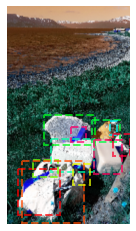

In [43]:
fig,ax = plt.subplots(1)
plt.axis('off')
plt.imshow(image)

# Show annotations
for box in img_annots['bbox']:
    color = colorsys.hsv_to_rgb(np.random.random(),1,1)
    
    rect = Rectangle((box[0],box[1]),box[2],box[3],linewidth=2,edgecolor=color,
                    facecolor='none', alpha=0.7, linestyle = '--')
    ax.add_patch(rect)

plt.show()

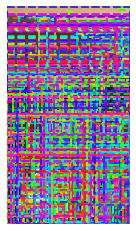

In [37]:
fig,ax = plt.subplots(1)
plt.axis('off')
plt.imshow(image)

# Show annotations
for box in prop:
    #print(box)
    color = colorsys.hsv_to_rgb(np.random.random(),1,1)
    
    rect = Rectangle((box[0],box[1]),box[2],box[3],linewidth=2,edgecolor=color,
                    facecolor='none', alpha=0.7, linestyle = '--')
    ax.add_patch(rect)

plt.show()

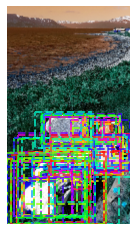

In [38]:
fig,ax = plt.subplots(1)
plt.axis('off')
plt.imshow(image)

# Show annotations
j = 0
for box in prop:
    if prop_categories[j] != 'background':
        #print(box)
        color = colorsys.hsv_to_rgb(np.random.random(),1,1)

        rect = Rectangle((box[0],box[1]),box[2],box[3],linewidth=2,edgecolor=color,
                        facecolor='none', alpha=0.7, linestyle = '--')
        ax.add_patch(rect)
    j+=1

plt.show()

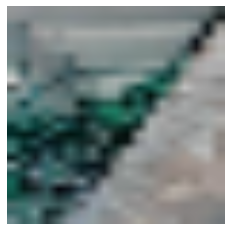

In [39]:
# Plot one of the cropped and resized images
fig,ax = plt.subplots(1)
plt.axis('off')
plt.imshow(cropped_resized_images[15])

# Apply a CNN to proposal regions for training and validation

In [83]:
import torch

d = data[0]
labels = data[1]
target_back_or_not = []
for i in labels:
    if i == 'background': target_back_or_not.append(0)
    else: target_back_or_not.append(1)
target_back_or_not = np.array(target_back_or_not)

print('target train 0/1: {}/{}'.format(
    len(np.where(target_back_or_not == 0)[0]), len(np.where(target_back_or_not == 1)[0])))

class_sample_count = np.array(
    [len(np.where(target_back_or_not == t)[0]) for t in np.unique(target_back_or_not)])

print(class_sample_count)
weight = 1. / class_sample_count
samples_weight = np.array([weight[t] for t in target_back_or_not])
print(samples_weight)
samples_weight = torch.from_numpy(samples_weight)
samples_weigth = samples_weight.double()
sampler = WeightedRandomSampler(samples_weight, len(samples_weight))

target train 0/1: 1386/193
[1386  193]
[0.0007215 0.0007215 0.0007215 ... 0.0007215 0.0007215 0.0007215]


In [1]:
import json
import torch
import torch.optim as optim
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, WeightedRandomSampler
import torch.nn.functional as F
from tqdm.notebook import tqdm
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold

from torchvision import datasets, models, transforms
import torch.backends.cudnn as cudnn
from torch.optim import lr_scheduler
import torch.optim as optim
import PIL.Image as Image
from PIL import Image

torch.cuda.empty_cache()
IMG_RESOLUTION = 224
EPOCHS = 19
LR = 0.005
BATCH_SIZE = 64


transform = transforms.Compose([
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
    
test_transform = transforms.Compose([ 
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

In [2]:
#dataset_path = '/zhome/82/e/180411/project_1/DeepLearning-in-ComputerVision/project-1.2/src/data_orig/split_dataset/'
#train_label = np.load(dataset_path + 'train_labels.npy',allow_pickle=True)
#train_data = np.load(dataset_path + 'train_images.npy',allow_pickle=True)

#validation_label = np.load(dataset_path + 'val_labels.npy',allow_pickle=True)
#validation_data = np.load(dataset_path + 'val_images.npy',allow_pickle=True)

dataset_path = '/zhome/82/e/180411/project_1/DeepLearning-in-ComputerVision/project-1.2/src/data/split_dataset/'
train_label = np.load(dataset_path + 'train/train_labels.npy',allow_pickle=True)
train_data = np.load(dataset_path + 'train/train_image.npy',allow_pickle=True)
#train_files = np.load(dataset_path + 'train/train_filenames.npy',allow_pickle=True)

validation_label = np.load(dataset_path + 'val/val_labels.npy',allow_pickle=True)
validation_data = np.load(dataset_path + 'val/val_image.npy',allow_pickle=True)

test_label = np.load(dataset_path + 'test/test_labels.npy',allow_pickle=True)
test_data = np.load(dataset_path + 'test/test_image.npy',allow_pickle=True)
test_figurenames = np.load(dataset_path + 'test/test_filenames.npy',allow_pickle=True)
test_boxes = np.load(dataset_path + 'test/test_boxes.npy',allow_pickle=True)

In [3]:
from sklearn import preprocessing
super_categories = ['background','Aluminium foil', 'Battery', 'Blister pack', 'Bottle', 
                    'Bottle cap', 'Broken glass', 'Can', 'Carton', 'Cup', 'Food waste', 
                    'Glass jar', 'Lid', 'Other plastic', 'Paper', 'Paper bag', 'Plastic bag & wrapper', 
                    'Plastic container', 'Plastic glooves', 'Plastic utensils', 'Pop tab', 'Rope & strings', 
                    'Scrap metal', 'Shoe', 'Squeezable tube', 'Straw', 'Styrofoam piece',
                    'Unlabeled litter', 'Cigarette']

le = preprocessing.LabelEncoder()
le.fit(super_categories)

train_dataset = []
for i in range(len(train_data)):
    train_dataset = train_dataset + train_data[i]
    
train_labelset = []
for i in range(len(train_label)):
    train_labelset = train_labelset + train_label[i]
train_targets = le.transform(train_labelset)

final_train_data = []
for index_im, im in enumerate(train_dataset):
    image = Image.fromarray(np.uint8(im))
    #print(image)
    final_train_data.append((transform(image),torch.as_tensor(train_targets[index_im])))
    
validation_dataset = []
for i in range(len(validation_data)):
    validation_dataset = validation_dataset + validation_data[i]
    
validation_labelset = []
for i in range(len(validation_label)):
    validation_labelset = validation_labelset + validation_label[i]
validation_targets = le.transform(validation_labelset)
    
final_validation_data = []
for index_im, im in enumerate(validation_dataset):
    image = Image.fromarray(np.uint8(im))
    final_validation_data.append((transform(image),torch.as_tensor(validation_targets[index_im])))

test_dataset = []
for i in range(len(test_data)):
    test_dataset = test_dataset + test_data[i]
    
test_labelset = []
test_fns = []
test_bbs = []
for i in range(len(test_label)):
    test_labelset = test_labelset + test_label[i]
    test_fns = test_fns + test_figurenames[i]
    test_bbs = test_bbs + list(test_boxes[i])
test_targets = le.transform(test_labelset)
    
final_test_data = []
for index_im, im in enumerate(test_dataset):
    image = Image.fromarray(np.uint8(im))
    final_test_data.append((transform(image),torch.as_tensor(test_targets[index_im])))    
    

In [5]:
np.argwhere(np.array(train_labelset)!='background')

array([[   21],
       [  120],
       [  171],
       [  196],
       [  204],
       [  635],
       [  707],
       [  733],
       [  802],
       [  847],
       [  946],
       [  950],
       [  972],
       [ 1039],
       [ 1059],
       [ 1068],
       [ 1074],
       [ 1084],
       [ 1091],
       [ 1103],
       [ 1104],
       [ 1115],
       [ 1116],
       [ 1124],
       [ 1126],
       [ 1127],
       [ 1218],
       [ 1243],
       [ 1396],
       [ 1411],
       [ 1461],
       [ 1498],
       [ 1550],
       [ 1767],
       [ 1848],
       [ 1874],
       [ 1901],
       [ 1959],
       [ 1973],
       [ 1990],
       [ 1993],
       [ 2003],
       [ 2014],
       [ 2033],
       [ 2046],
       [ 2106],
       [ 2115],
       [ 2146],
       [ 2189],
       [ 2195],
       [ 2204],
       [ 2243],
       [ 2244],
       [ 2263],
       [ 2272],
       [ 2275],
       [ 2306],
       [ 2308],
       [ 2348],
       [ 2380],
       [ 2393],
       [ 2405],
       [

In [64]:
len(test_bbs)

16028

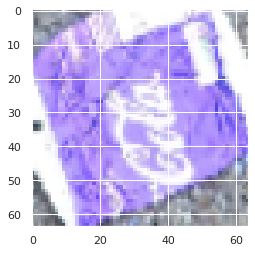

In [6]:
import matplotlib.pyplot as plt
plt.imshow(train_dataset[1901])

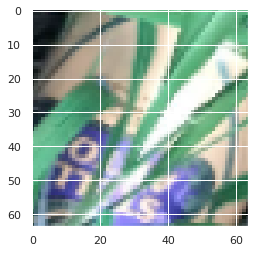

In [7]:
np.argwhere(np.array(validation_labelset)!='background')

import matplotlib.pyplot as plt
plt.imshow(validation_dataset[399])

In [8]:
validation_loader = DataLoader(final_validation_data, batch_size=64, shuffle=False, num_workers=3)

In [9]:
from copy import deepcopy
from torch.utils.data import DataLoader, WeightedRandomSampler
labels = deepcopy(train_labelset)
target_back_or_not = []
for i in labels:
    if i == 'background': target_back_or_not.append(0)
    else: target_back_or_not.append(1)
target_back_or_not = np.array(target_back_or_not)
print('target train 0/1: {}/{}'.format(
    len(np.where(target_back_or_not == 0)[0]), len(np.where(target_back_or_not == 1)[0])))

class_sample_count = np.array(
    [len(np.where(target_back_or_not == t)[0]) for t in np.unique(target_back_or_not)])

#weight = 1. / class_sample_count
#samples_weight = np.array([weight[t] for t in target_back_or_not])

samples_weight = []
for t in target_back_or_not:
    if t == 0: samples_weight.append(1)
    else: samples_weight.append(16)

samples_weight = torch.from_numpy(np.array(samples_weight))
samples_weigth = samples_weight.double()
sampler = WeightedRandomSampler(samples_weight, len(samples_weight))

target train 0/1: 76944/993


In [10]:
(76936./990)*0.25

19.42828282828283

In [11]:
train_loader = DataLoader(final_train_data, batch_size=64, sampler = sampler,num_workers=3)

In [12]:
def train(model, optimizer, train_loader, validation_loader, num_epochs):
    def loss_fun(output, target):
        return F.cross_entropy(output, target)
        #return F.binary_cross_entropy(output, target)
    out_dict = {'train_acc': [],
              'test_acc': [],
              'train_loss': [],
              'test_loss': []}
    for epoch in tqdm(range(num_epochs), unit='epoch'):
        model.train()
        #For each epoch
        train_correct = 0
        train_loss = []
        for minibatch_no, (data, target) in tqdm(enumerate(train_loader), total=len(train_loader)):
            data, target = data.to(device), target.to(device)
            #Zero the gradients computed for each weight
            optimizer.zero_grad()
            #Forward pass your image through the network
            output = model(data)
            #print(output)
            #Compute the loss
            loss = loss_fun(output, target)
            #Backward pass through the network
            loss.backward()
            #Update the weights
            optimizer.step()

            train_loss.append(loss.item())
            #Compute how many were correctly classified
            predicted = output.argmax(1)

            train_correct += (target==predicted).sum().cpu().item()

            
        #print(train_correct)
        #Comput the test accuracy
        test_loss = []
        test_correct = 0
        model.eval()
        for data, target in validation_loader:
            data, target = data.to(device), target.to(device)
            with torch.no_grad():
                output = model(data)
            test_loss.append(loss_fun(output, target).cpu().item())
            predicted = output.argmax(1)
            test_correct += (target==predicted).sum().cpu().item()
            
        out_dict['train_acc'].append(train_correct/len(train_targets))
        out_dict['test_acc'].append(test_correct/len(validation_targets))
        out_dict['train_loss'].append(np.mean(train_loss))
        out_dict['test_loss'].append(np.mean(test_loss))
        print(f"Loss train: {np.mean(train_loss):.3f}\t test: {np.mean(test_loss):.3f}\t",
              f"Accuracy train: {out_dict['train_acc'][-1]*100:.1f}%\t test: {out_dict['test_acc'][-1]*100:.1f}%")

    return out_dict

In [13]:
from torchvision import datasets, models, transforms

if torch.cuda.is_available():
    print("The code will run on GPU.")
else:
    print("The code will run on CPU. Go to Edit->Notebook Settings and choose GPU as the hardware accelerator")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_ft = models.resnet152(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Sequential(nn.Linear(num_ftrs, 29))
model_ft = model_ft.to(device)

optimizer = torch.optim.Adam(model_ft.parameters())

out_dict_resnet = train(model_ft, optimizer, train_loader, validation_loader, 3)

The code will run on GPU.


  0%|          | 0/2 [00:00<?, ?epoch/s]

  0%|          | 0/1218 [00:00<?, ?it/s]

Loss train: 0.146	 test: 0.404	 Accuracy train: 96.5%	 test: 97.8%


  0%|          | 0/1218 [00:00<?, ?it/s]

Loss train: 0.059	 test: 0.184	 Accuracy train: 98.4%	 test: 98.3%


In [14]:
test_loader = DataLoader(final_test_data, batch_size=64, shuffle=False, num_workers=3)

In [140]:
def loss_fun(output, target):
    return F.cross_entropy(output, target)
model_ft.eval()
test_loss = []
test_correct = 0
targets = np.array([])
predictions = np.array([])
scores = np.array([])

for data, target in test_loader:
    data, target = data.to(device), target.to(device)
    with torch.no_grad():
        output = model_ft(data)
    test_loss.append(loss_fun(output, target).cpu().item())
    predicted = output.argmax(1)
    scor = torch.max(output, 1)[0]
    test_correct += (target==predicted).sum().cpu().item()
    targets = np.concatenate((targets,target.cpu().detach().numpy()))
    predictions = np.concatenate((predictions,predicted.cpu().detach().numpy()))
    scores = np.concatenate((scores,scor.cpu().detach().numpy()))
    


In [36]:
# All project code without other things
%matplotlib inline
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import cv2

dataset_path = '/dtu/datasets1/02514/data_wastedetection'
anns_file_path = dataset_path + '/' + 'annotations.json'

# Read annotations
with open(anns_file_path, 'r') as f:
    dataset = json.loads(f.read())
    
from copy import deepcopy
import colorsys
from matplotlib.patches import Polygon, Rectangle


def get_image_ground_truth(filename):
    #----------------------------------------------
    # Function to find the ground truth annotation for each resized image 
    #----------------------------------------------

    # Find the image id in the annotation file
    for img in dataset['images']:
        if img['file_name'] == filename:
            my_img = deepcopy(img)

    if my_img['width'] > 512 or my_img['height'] > 512:
        if my_img['width'] > my_img['height']:
            new_width = 512
            new_height = int(my_img['height'] * (512./my_img['width']))
        elif my_img['height'] > my_img['width']:
            new_height = 512
            new_width = int(my_img['width'] * (512./my_img['height']))
        else:
            new_width = 512
            new_height = 512
        
    w_factor = float(new_width)/my_img['width']
    h_factor = float(new_height)/my_img['height']

    # Finding all the annotations for one image - maybe try to optimize it by using pandas?
    img_annots = {}
    img_annots['id'] = []
    img_annots['bbox'] = []
    img_annots['category_id'] = []
    img_annots['supercategory'] = []
    img_annots['orig_size'] = [my_img['width'], my_img['height']]
    img_annots['new_size'] = [new_width, new_height]
                                       
    for annot in dataset['annotations']:
        if annot['image_id'] == my_img['id']:
            #print(annot['id'], annot['bbox'], annot['category_id'])#, dataset['categories']['id'][annot['id']])
            img_annots['id'].append(annot['id'])
            img_annots['bbox'].append([round(annot['bbox'][0]*w_factor,1), round(annot['bbox'][1]*h_factor,1), round(annot['bbox'][2]*w_factor,1), round(annot['bbox'][3]*h_factor,1)])
            img_annots['category_id'].append(annot['category_id'])
            for cat in dataset['categories']:
                if cat['id'] == annot['category_id']:
                    #print(cat['supercategory'])
                    img_annots['supercategory'].append(cat['supercategory'])
                    
    return img_annots

In [141]:
file_path = '/dtu/datasets1/02514/data_wastedetection/'
background_number = le.transform(np.array(['background']))[0]

unique_files = np.unique(np.array(test_fns))

# Do this for all files
# indeces for the boxes in this file
first_file = np.argwhere(np.array(test_fns) == unique_files[6]) 
# indeces in first file for those with no background prediction
pred_not_background_first_file = np.argwhere(predictions[first_file]!=background_number)[:,0]
# indeces for the boxes with positive predictions
pred_not_background_first_file_index = first_file[pred_not_background_first_file]

# The boxes retained and their predictions
boxes_retained = [test_bbs[pred_not_background_first_file_index[i][0]] for i in range(len(pred_not_background_first_file))] 
predictions_retained = predictions[pred_not_background_first_file_index]
scores_retained = scores[pred_not_background_first_file_index]

ious = np.zeros([len(pred_not_background_first_file_index),len(pred_not_background_first_file_index)])
for i in range(len(pred_not_background_first_file_index)):
    for j in range(len(pred_not_background_first_file_index)):
        ious[i,j] = get_iou(boxes_retained[i],boxes_retained[j])

 

# NMS        
#for y in range(len(ious[:,0])):
boxes_left = []
category_boxes_left = []
ixs = scores_retained.argsort()[::-1]
print(ixs)

# order the boxes by score and get the rearranged indexes
# find the IoU of the boxes between each other

[[0]
 [0]
 [0]
 [0]]
The history saving thread hit an unexpected error (OperationalError('unable to open database file')).History will not be written to the database.


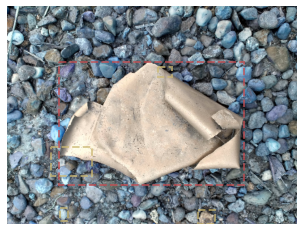

In [129]:
image = cv2.imread(file_path + unique_files[6])

img_annots = get_image_ground_truth(unique_files[6])

image = cv2.resize(image,(img_annots['new_size'][0],img_annots['new_size'][1]))

fig,ax = plt.subplots(1)
plt.axis('off')
plt.imshow(image)

# Show annotations
for box in img_annots['bbox']:
    #color = colorsys.hsv_to_rgb(np.random.random(),1,1)
    
    rect = Rectangle((box[0],box[1]),box[2],box[3],linewidth=2,edgecolor='r',
                    facecolor='none', alpha=0.7, linestyle = '--')
    ax.add_patch(rect)
    
for x in range(len(pred_not_background_first_file_index)):
    #ind = pred_not_background_first_file_index[x][0]
    #print(ind)
    #print(test_bbs[ind])
    rect = Rectangle((test_bbs[pred_not_background_first_file_index[x][0]][0],test_bbs[pred_not_background_first_file_index[x][0]][1]),test_bbs[pred_not_background_first_file_index[x][0]][2],test_bbs[pred_not_background_first_file_index[x][0]][3],linewidth=2,edgecolor='y',
                    facecolor='none', alpha=0.7, linestyle = '--')
    ax.add_patch(rect)


plt.show()

In [123]:
le.inverse_transform(np.array(predictions[pred_not_background_first_file_index],dtype=int))

array(['Styrofoam piece', 'Styrofoam piece', 'Other plastic',
       'Bottle cap'], dtype='<U21')

In [124]:
pred_not_background_first_file_index

array([[6493],
       [6557],
       [6567],
       [7288]])

In [127]:
predictions[pred_not_background_first_file_index]

array([[26.],
       [26.],
       [13.],
       [ 4.]])